In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image, ImageDraw, ImageFont, ImageOps
import matplotlib.pyplot as plt
import seaborn as sns
import re
from shutil import copy2
import ast
import cv2

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint
import pocketsphinx

## Bag 1 : Classification Hijaiyah

### Labelling

In [2]:
with open('label_mapping.txt', 'r') as file:
    content = file.read()

# Find the positions of the two dictionaries
start1 = content.find('number_to_text')
end1 = content.find('}', start1) + 1
dict1_str = content[start1:end1]
number_to_text = ast.literal_eval(dict1_str.split('=')[1].strip())

start2 = content.find('lab_to_number')
end2 = content.find('}', start2) + 1
dict2_str = content[start2:end2]
lab_to_number = ast.literal_eval(dict2_str.split('=')[1].strip())

start3 = content.find('lab_to_text')
end3 = content.find('}', start3) + 1
dict3_str = content[start3:end3]
lab_to_text = ast.literal_eval(dict3_str.split('=')[1].strip())


### menambahkan data baru

In [3]:
def create_new_data_train(path_source, path_destination, exten_source, n_data, dict):
    for label, text in dict.items():
    # Load the original image
        img_path = f'{path_source}/{text}.{exten_source}'
        img = load_img(img_path, color_mode='rgb')  # Change color_mode if necessary
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
    
        # Create an ImageDataGenerator with augmentation options
        datagen = ImageDataGenerator(
            brightness_range=[0.2, 1.5],
            rotation_range=30,      # Meningkatkan rotation range
            shear_range=0.3,
            zoom_range=0.1,         # Menambahkan zoom range
            width_shift_range=0.1,  # Menambahkan width shift
            height_shift_range=0.1, # Menambahkan height shift
            fill_mode='nearest',    # Mode pengisian
            validation_split=0.2    # Split validation
        )
    
        # Generate 480 augmented images
        save_dir = f'{path_destination}/{label}'
        os.makedirs(save_dir, exist_ok=True)
    
        i = 0
        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=save_dir, save_prefix='aug', save_format='png'):
            i += 1
            if i >= n_data:
                break
            
        print(f"{n_data} augmented {text} images have been saved to the '{path_destination}' directory.")


In [4]:
create_new_data_train('data/example_1', 'data/hw_aug_digi', 'jpg', 600, lab_to_text)
create_new_data_train('data/example_2', 'data/hw_aug_digi', 'jpg', 600, lab_to_text)
create_new_data_train('data/example_3', 'data/hw_aug_digi', 'png', 600, lab_to_text)

600 augmented alif images have been saved to the 'data/hw_aug_digi' directory.
600 augmented ba images have been saved to the 'data/hw_aug_digi' directory.
600 augmented ta images have been saved to the 'data/hw_aug_digi' directory.
600 augmented tsa images have been saved to the 'data/hw_aug_digi' directory.
600 augmented jim images have been saved to the 'data/hw_aug_digi' directory.
600 augmented ha images have been saved to the 'data/hw_aug_digi' directory.
600 augmented kho images have been saved to the 'data/hw_aug_digi' directory.
600 augmented dal images have been saved to the 'data/hw_aug_digi' directory.
600 augmented dzal images have been saved to the 'data/hw_aug_digi' directory.
600 augmented ra images have been saved to the 'data/hw_aug_digi' directory.
600 augmented zai images have been saved to the 'data/hw_aug_digi' directory.
600 augmented sin images have been saved to the 'data/hw_aug_digi' directory.
600 augmented syin images have been saved to the 'data/hw_aug_digi

### Memisahkan dataset sesuai label

In [ ]:
# memisahkan data di folder utama menjadi sub folder dengan warna tulisan hitam dan background putih
source_folder = r"C:\Users\gagah\Desktop\KKN\data\Train Images 13440x32x32\train"
destination_folder = r"C:\Users\gagah\Desktop\KKN\data\Data_Train_Images"

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)
file_list = [f for f in os.listdir(source_folder) if f.endswith(".jpg") or f.endswith(".png")]

for filename in file_list:
    match = re.search(r'id_(\d+)_label_(\d+)', filename)
    if match:
        img_id = match.group(1)
        label = match.group(2)
        
        # Membuat path folder label
        label_folder = os.path.join(destination_folder, f'lab_{label}')
        if not os.path.exists(label_folder):
            os.makedirs(label_folder)
        
        # Memuat dan menginversi gambar
        src_path = os.path.join(source_folder, filename)
        img = Image.open(src_path)
        img = ImageOps.invert(img)
        
        # Menyimpan gambar yang telah diubah ke folder tujuan dengan nama file baru
        dest_path = os.path.join(label_folder, f'id_{img_id}.png')
        img.save(dest_path)

### Menampilkan gambar dataset

In [ ]:
base_folder = "data/hw_aug_digi"
images_per_row = 8
size = 128

def extract_number(filename):
    match = re.search(r'_(\d+)', filename)
    return int(match.group(1)) if match else -1

folders = [f for f in os.listdir(base_folder)]
sorted_folders = sorted(folders, key=extract_number)

for label in sorted_folders:
    images_with_filenames = []
    
    label_directory = os.path.join(base_folder, label)
    file_list = [f for f in os.listdir(label_directory) if f.endswith(".png")]
    file_list.sort(key=extract_number)

    for filename in file_list:
        img_path = os.path.join(label_directory, filename)
        img = Image.open(img_path).convert('L')  # Convert to grayscale if not already
        img = img.resize((size, size))
        img_array = np.array(img)
        images_with_filenames.append((img_array, filename))

    # Convert list of image arrays to a NumPy array
    images = np.array([img[0] for img in images_with_filenames])
    
    print(f'Total data gambar: {len(images)}')
    print(f'Shape setiap gambar: {images[0].shape}')

    # Plot the images
    fig, axes = plt.subplots(1, min(images_per_row, len(images)), figsize=(10, 1.5))
    axes = axes.ravel()
    for i in range(min(images_per_row, len(images))):
        axes[i].imshow(images_with_filenames[i][0], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(images_with_filenames[i][1], fontsize=8)

    plt.suptitle(f'Label {lab_to_text[label]}')
    plt.tight_layout()
    plt.show()


### Membuat model DeepLearning

In [5]:
model_dir = 'model_h5'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') > 0.90 and logs.get('val_accuracy') > 0.90:
                print("\nReached 90% accuracy so cancelling training!")
                print(f"accuracy : {logs.get('accuracy') * 100:.2f}% \n"
                      f"val_acc : {logs.get('val_accuracy') * 100:.2f}% \n")
                self.model.stop_training = True
    
datagen = ImageDataGenerator(
    rescale=1./255,
    #horizontal_flip=True,
    #vertical_flip=True,
    brightness_range=[0.5, 1.5],
    rotation_range=5,      # Meningkatkan rotation range
    shear_range=0.1,
    zoom_range=0.1,         # Menambahkan zoom range
    width_shift_range=0.1,  # Menambahkan width shift
    height_shift_range=0.1, # Menambahkan height shift
    fill_mode='nearest',    # Mode pengisian
    validation_split=0.2    # Split validation
)

train_generator = datagen.flow_from_directory(
    directory=base_folder,
    target_size=(size, size),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training' 
)

validation_generator = datagen.flow_from_directory(
    directory=base_folder,
    target_size=(size, size),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation'
)

model = tf.keras.models.Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(size, size, 1)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(folders), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(model_dir, 'model_5_{epoch:02d}_{accuracy:.2f}_{val_accuracy:.2f}.h5'), 
    monitor='val_accuracy',    # Metrik yang dipantau
    save_best_only=True,       # Hanya menyimpan model terbaik
    mode='max',                # Mode 'max' karena kita ingin akurasi maksimum
    verbose=1                  # Menampilkan log setiap kali model disimpan
)

Found 47632 images belonging to 28 classes.
Found 11894 images belonging to 28 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                  

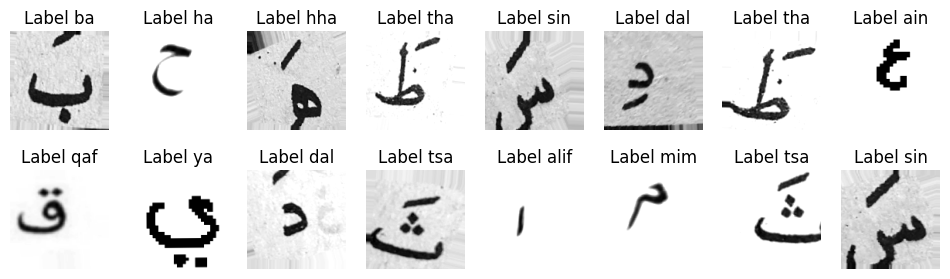

In [6]:
for images, labels in train_generator:
    plt.figure(figsize=(12, 3.3))
    for i in range(16):
        plt.subplot(2, 8, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label {number_to_text[labels[i].argmax()]}')
        plt.axis('off')
    plt.show()
    break

Epoch 1/100
1489/1489 [==============================] - ETA: 0s - loss: 1.2913 - accuracy: 0.6051
Epoch 1: val_accuracy improved from -inf to 0.91845, saving model to model\model_5_01_0.61_0.92.h5
1489/1489 [==============================] - 822s 551ms/step - loss: 1.2913 - accuracy: 0.6051 - val_loss: 0.2601 - val_accuracy: 0.9184
Epoch 2/100


c:\Users\gagah\Desktop\KKN\.conda\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1489/1489 [==============================] - ETA: 0s - loss: 0.3024 - accuracy: 0.9059
Epoch 2: val_accuracy improved from 0.91845 to 0.97637, saving model to model\model_5_02_0.91_0.98.h5

Reached 90% accuracy so cancelling training!
accuracy : 90.59% 
val_acc : 97.64% 

1489/1489 [==============================] - 487s 327ms/step - loss: 0.3024 - accuracy: 0.9059 - val_loss: 0.0753 - val_accuracy: 0.9764


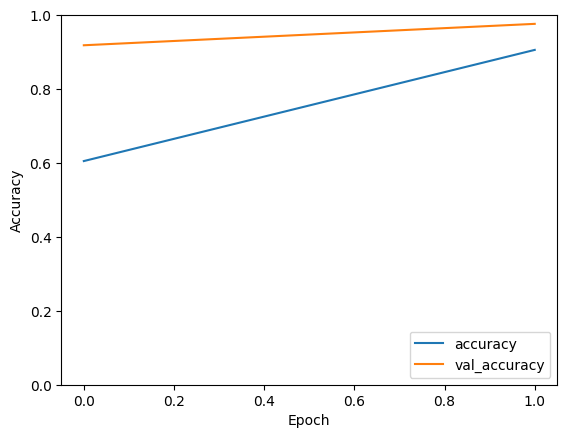

In [7]:
history = model.fit(
    train_generator,        
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback, myCallback()]
)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

### Evaluation model

size = (128,128)
chanel = grayscale

1861/1861 [==============================] - 148s 79ms/step


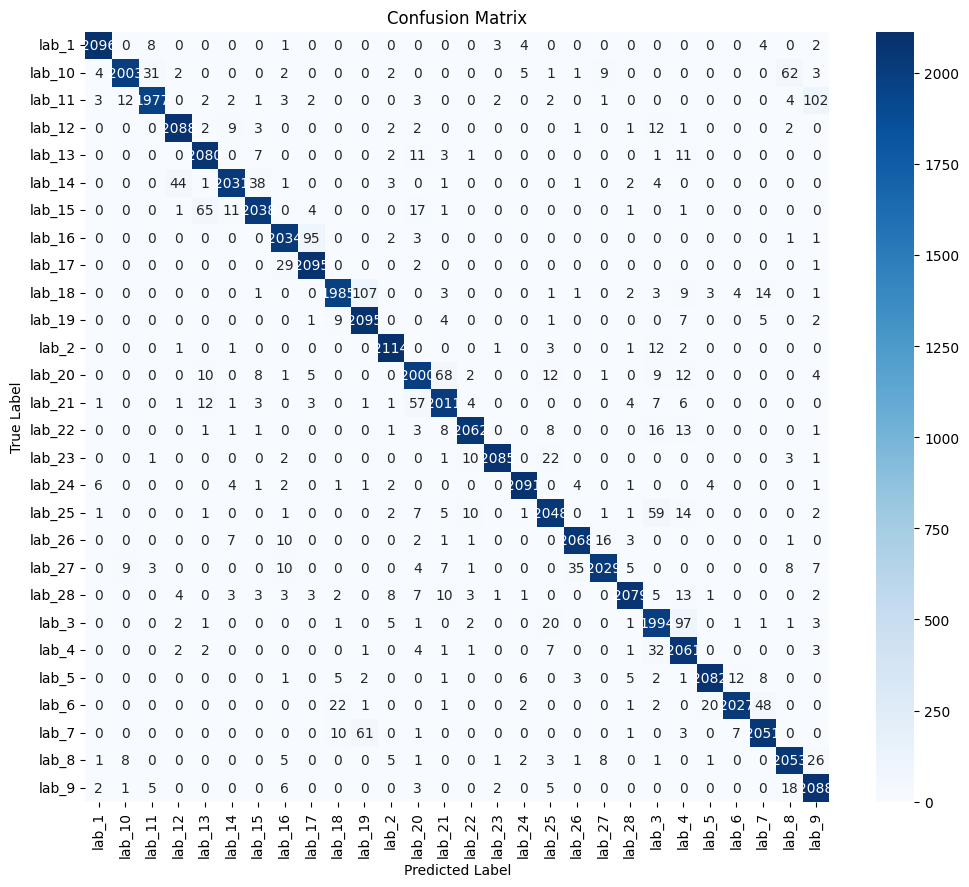

              precision    recall  f1-score   support

       lab_1       0.99      0.99      0.99      2118
      lab_10       0.99      0.94      0.96      2125
      lab_11       0.98      0.93      0.95      2116
      lab_12       0.97      0.98      0.98      2123
      lab_13       0.96      0.98      0.97      2116
      lab_14       0.98      0.96      0.97      2126
      lab_15       0.97      0.95      0.96      2139
      lab_16       0.96      0.95      0.96      2136
      lab_17       0.95      0.98      0.97      2127
      lab_18       0.98      0.93      0.95      2134
      lab_19       0.92      0.99      0.95      2124
       lab_2       0.98      0.99      0.99      2135
      lab_20       0.94      0.94      0.94      2132
      lab_21       0.95      0.95      0.95      2112
      lab_22       0.98      0.97      0.98      2115
      lab_23       1.00      0.98      0.99      2125
      lab_24       0.99      0.99      0.99      2118
      lab_25       0.96    

In [8]:
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    img = load_img(image_path, color_mode='grayscale', target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

def load_images_from_folders(base_folder):
    images = []
    labels = []
    class_names = os.listdir(base_folder)
    
    for class_index, class_name in enumerate(class_names):
        class_folder = os.path.join(base_folder, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                if filename.endswith(".png"):
                    img_path = os.path.join(class_folder, filename)
                    img_array = load_and_preprocess_image(img_path)
                    images.append(img_array)
                    labels.append(class_index)
    
    images = np.vstack(images)  # Combine all images into one large array
    labels = np.array(labels)
    return images, labels, class_names

# Load the model
model = load_model('model_h5/model_5_02_0.91_0.98.h5')

# Path to the dataset folder
base_folder = 'data/hw_aug_digi'

# Load and preprocess images
images, true_labels, class_names = load_images_from_folders(base_folder)

# Predict the class
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Display confusion matrix with new labels
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report with new labels
print(classification_report(true_labels, predicted_classes, target_names=class_names))

1/1 [==============================] - 0s 84ms/step


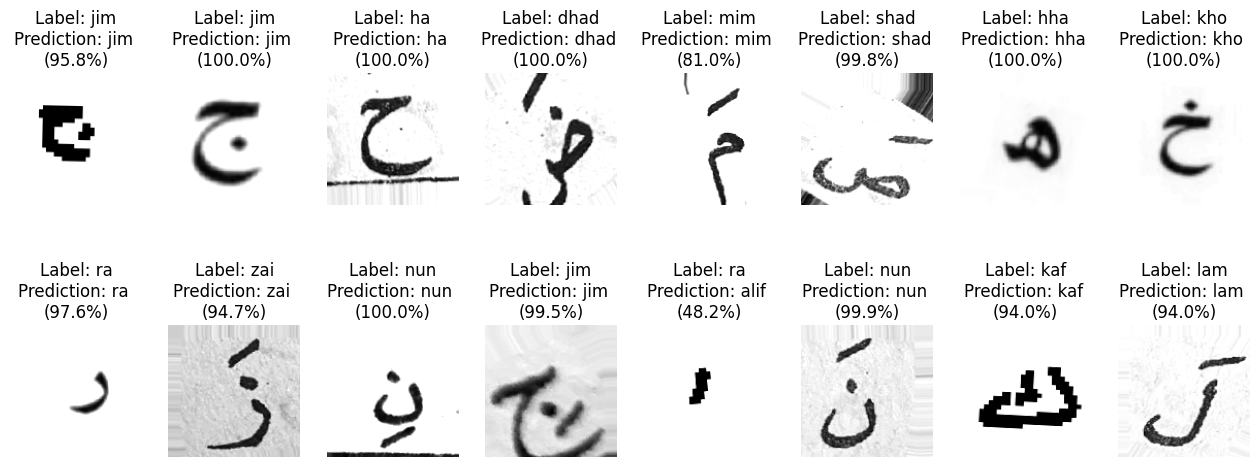

In [15]:
# Mengambil satu batch gambar dan label dari generator
for images, labels in train_generator:
    # Melakukan prediksi dengan model
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    # Membuat plot untuk menampilkan gambar dengan label asli dan prediksi
    plt.figure(figsize=(16, 6))
    for i in range(16):
        plt.subplot(2, 8, i+1)
        plt.imshow(images[i].reshape(images[i].shape[0], images[i].shape[1]), cmap='gray')
        plt.axis('off')        
        plt.title("Label: {}\nPrediction: {} \n({:.1f}%)".format(
        number_to_text[labels[i].argmax()], 
        number_to_text[predicted_classes[i]], 
        np.max(predictions[i])*100
    ))
    
    # Menampilkan plot
    plt.show()
    break


### coba pada data diluar dataset

1/1 [==============================] - 0s 122ms/step


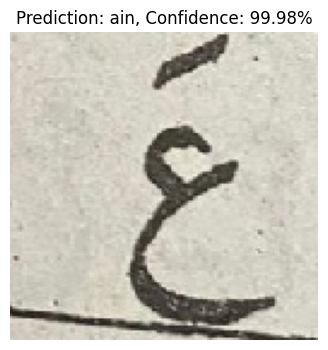

1/1 [==============================] - 0s 30ms/step


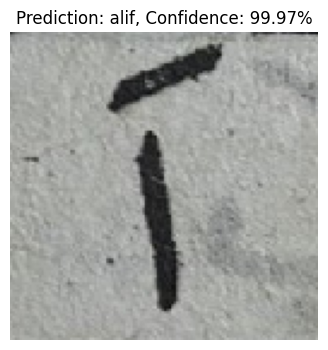

1/1 [==============================] - 0s 32ms/step


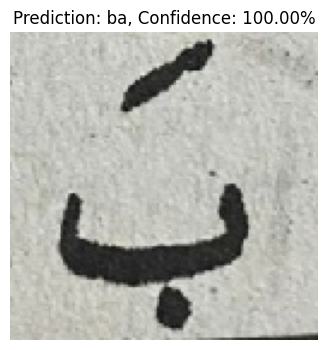

1/1 [==============================] - 0s 51ms/step


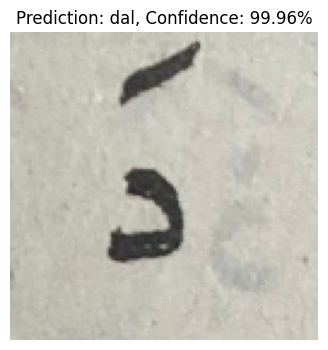

1/1 [==============================] - 0s 15ms/step


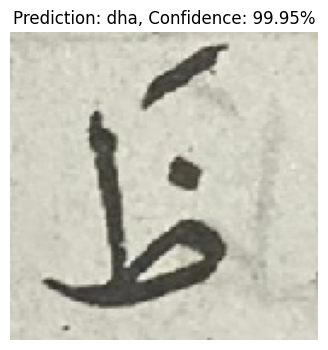

1/1 [==============================] - 0s 33ms/step


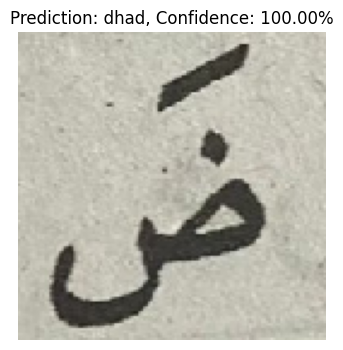

1/1 [==============================] - 0s 33ms/step


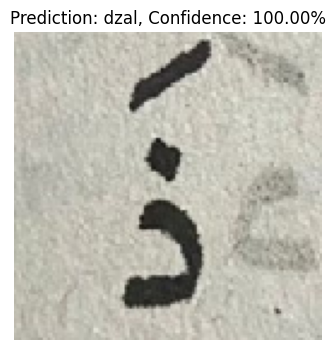

1/1 [==============================] - 0s 33ms/step


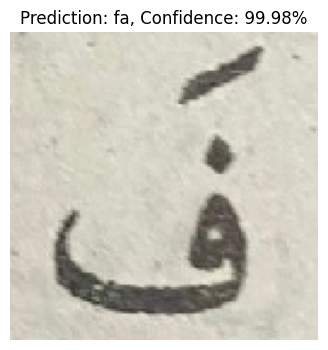

1/1 [==============================] - 0s 33ms/step


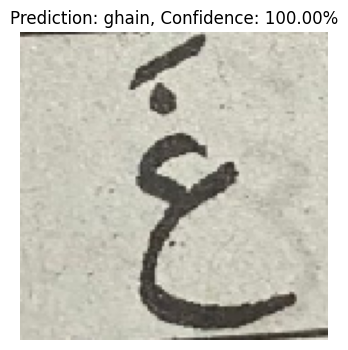

1/1 [==============================] - 0s 28ms/step


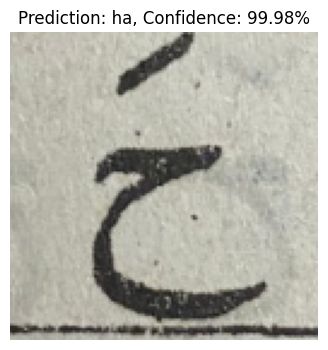

1/1 [==============================] - 0s 29ms/step


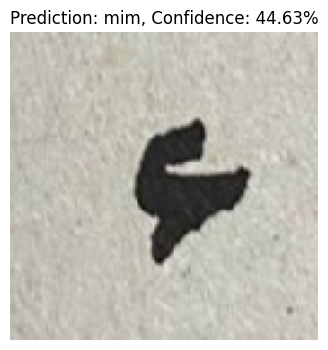

1/1 [==============================] - 0s 13ms/step


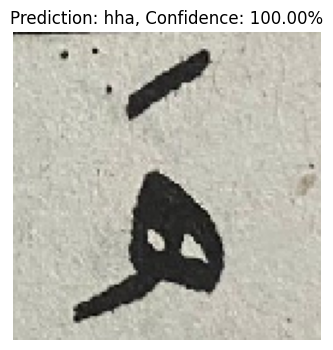

1/1 [==============================] - 0s 52ms/step


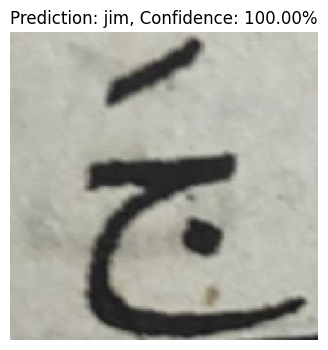

1/1 [==============================] - 0s 33ms/step


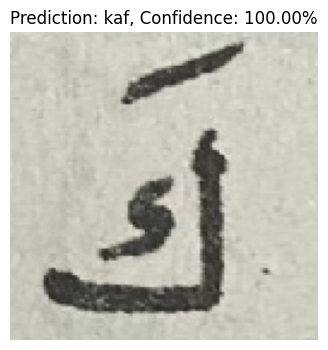

1/1 [==============================] - 0s 32ms/step


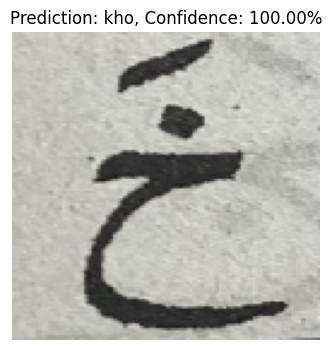

1/1 [==============================] - 0s 53ms/step


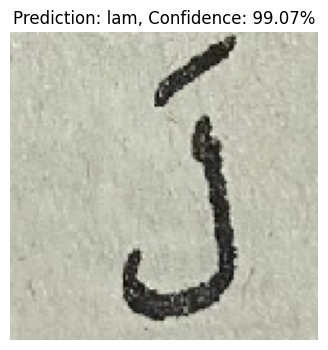

1/1 [==============================] - 0s 32ms/step


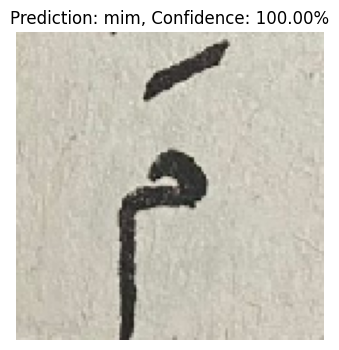

1/1 [==============================] - 0s 16ms/step


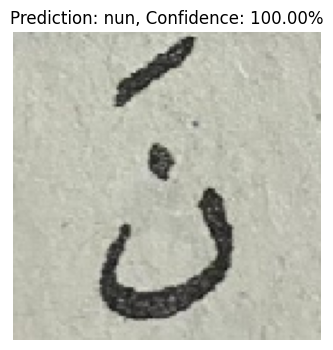

1/1 [==============================] - 0s 22ms/step


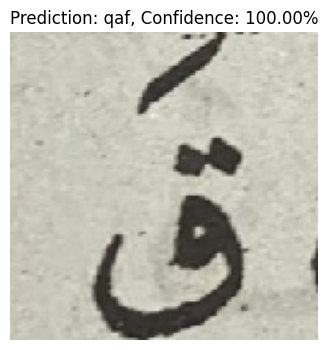

1/1 [==============================] - 0s 29ms/step


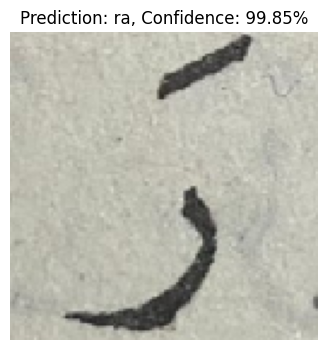

1/1 [==============================] - 0s 32ms/step


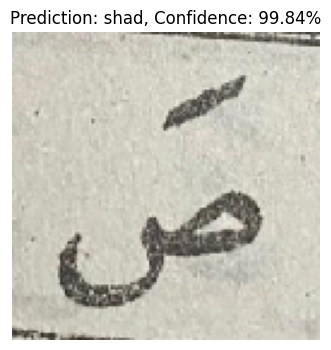

1/1 [==============================] - 0s 31ms/step


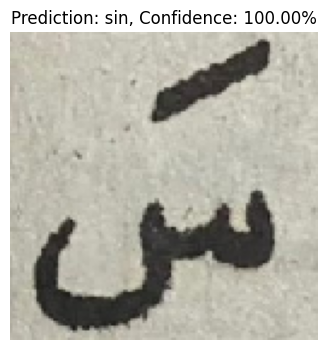

1/1 [==============================] - 0s 27ms/step


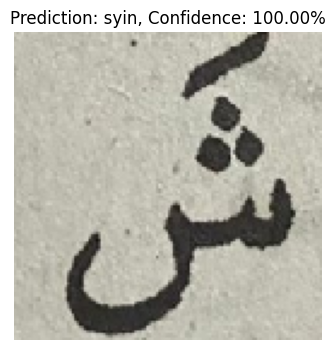

1/1 [==============================] - 0s 29ms/step


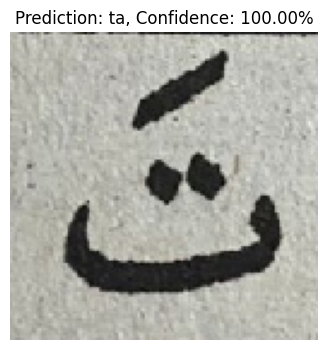

1/1 [==============================] - 0s 19ms/step


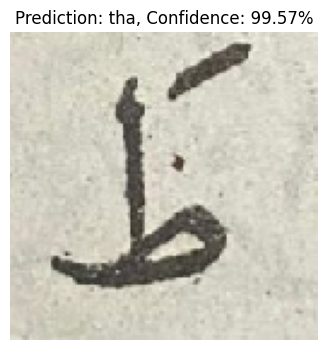

1/1 [==============================] - 0s 47ms/step


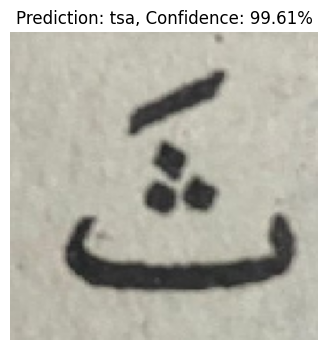

1/1 [==============================] - 0s 31ms/step


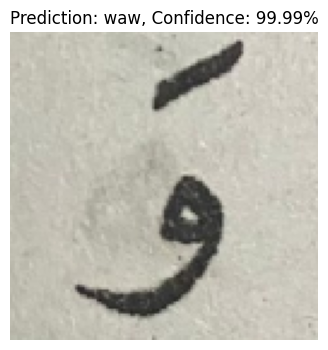

1/1 [==============================] - 0s 33ms/step


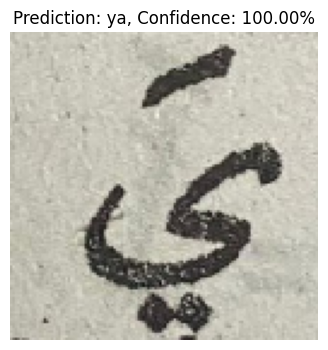

1/1 [==============================] - 0s 43ms/step


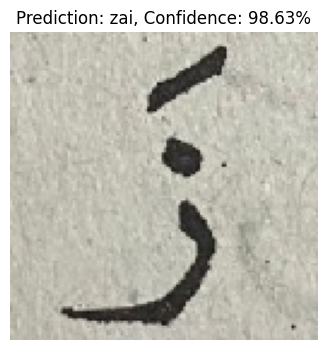

In [18]:
model = load_model('model_h5/model_5_02_0.91_0.98.h5')

# Directory containing images
image_folder = 'data/example_1'
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.png', '.jpeg', '.jpg'))]

for image_file in image_files:
    img_array = load_and_preprocess_image(image_file)
    prediction = model.predict(img_array)
    predicted_label = np.argmax(prediction)
    confidence = np.max(prediction) * 100

    img = load_img(image_file, target_size=(size, size), color_mode='rgb')

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f'Prediction: {number_to_text[predicted_label]}, Confidence: {confidence:.2f}%')
    plt.axis('off')
    plt.show()


### Ubah model menjadi TfLite

In [20]:
# Load model Keras (.h5)
model = load_model('model_h5/model_5_02_0.91_0.98.h5')

# Konversi model ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TensorFlow Lite (.tflite)
with open('model_tflite/model_5_02_0.91_0.98.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke .tflite")

INFO:tensorflow:Assets written to: C:\Users\gagah\AppData\Local\Temp\tmpvcp7bjv7\assets


INFO:tensorflow:Assets written to: C:\Users\gagah\AppData\Local\Temp\tmpvcp7bjv7\assets


Model berhasil dikonversi ke .tflite
